## import

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## prepare data

In [3]:
def generate_linear(n=100):
    pts = np.random.uniform(0, 1, (n, 2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0], pt[1]])
        # distance = (pt[0] - pt[1]) / 1.414
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(inputs), np.array(labels).reshape(n, 1)


def generate_XOR_easy():
    inputs = []
    labels = []

    for i in range(11):
        inputs.append([0.1 * i, 0.1 * i])
        labels.append(0)

        if 0.1 * i == 0.5:
            continue

        inputs.append([0.1 * i, 1 - 0.1 * i])
        labels.append(1)

    return np.array(inputs), np.array(labels).reshape(21, 1)

x, y = generate_linear(n = 100)
x, y = generate_XOR_easy()

## define model

In [12]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))


def derivative_sigmoid(x):
    return np.multiply(x, 1.0 - x)

class FC:
    def __init__(self, input_size: int, output_size: int):
        self.w = np.random.randn(input_size, output_size)
        self.b = np.random.randn(output_size)
        self.input = None
        self.output = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.input = x
        self.output = sigmoid(np.dot(x, self.w) + self.b)
        return self.output

    def backward(self, output_error: np.ndarray, learning_rate: float) -> np.ndarray:
        sigmoid_derivative = derivative_sigmoid(self.output)
        weights_error = np.dot(self.input.T, output_error * sigmoid_derivative)
        bias_error = np.sum(output_error * sigmoid_derivative, axis=0)

        # Update parameters
        self.w -= learning_rate * weights_error
        self.b -= learning_rate * bias_error

        input_error = np.dot(output_error * sigmoid_derivative, self.w.T)
        return input_error


class History:
    def __init__(self, loss: float, accuracy: float):
        self.loss = loss
        self.accuracy = accuracy


class Model:
    def __init__(self, layers_size: list):
        self.fcs = []
        self.train_histories = []
        self.test_histories = []
        for i in range(len(layers_size) - 1):
            self.fcs.append(FC(layers_size[i], layers_size[i + 1]))

    def forward(self, x: np.ndarray) -> np.ndarray:
        for fc in self.fcs:
            x = fc.forward(x)
        return x

    def backward(self, y: np.ndarray, lr: float = 0.01):
        loss_deriv = 2 * (self.fcs[-1].output - y) / y.size
        for fc in reversed(self.fcs):
            loss_deriv = fc.backward(loss_deriv, lr)

    def loss(self, y):
        return np.mean((self.fcs[-1].output - y) ** 2)

    def accuracy(self, y):
        return np.mean(np.round(self.fcs[-1].output) == y)

    def train(self, x, y, test_x, test_y, epochs, lr=0.01, batch_size=None, patience = None, verbose=True):
        if batch_size is None:
            batch_size = len(x)
        self.forward(x)
        self.train_histories.append(History(self.loss(y), self.accuracy(y)))
        self.forward(test_x)
        self.test_histories.append(History(self.loss(test_y), self.accuracy(test_y)))
        if verbose:
            print(f"Initial, Loss: {self.loss(test_y)}")

        best_loss = self.loss(test_y)
        epochs_since_best = 0
        for i in range(epochs):
            for j in range(0, len(x), batch_size):
                end = j + batch_size if j + batch_size < len(x) else len(x)
                x_batch = x[j : end]
                y_batch = y[j : end]
                self.forward(x_batch)
                self.backward(y_batch, lr)
            self.forward(x)
            self.train_histories.append(History(self.loss(y), self.accuracy(y)))
            self.forward(test_x)
            self.test_histories.append(History(self.loss(test_y), self.accuracy(test_y)))
            if verbose:
                print(f"Epoch {i}, Loss: {self.loss(test_y)}")
            if self.loss(test_y) < best_loss:
                best_loss = self.loss(test_y)
                epochs_since_best = 0
            else:
                epochs_since_best += 1
            if patience is not None and epochs_since_best >= patience:
                if verbose:
                    print(f"Early stopping at epoch {i}")
                break


"""
L = sum((a_j - y_j)^2) / n
L/a_j = 2(a_j - y_j) / n
L/a = 2(a - y) / n

a_k = sigmoid(sum(x_j * w_jk+ b_k))
a_k/w_jk = sigmoid'(sum(x_j * w_jk + b_k)) * x_j
a_k/b_k = sigmoid'(sum(x_j * w_jk + b_k))
"""

"\nL = sum((a_j - y_j)^2) / n\nL/a_j = 2(a_j - y_j) / n\nL/a = 2(a - y) / n\n\na_k = sigmoid(sum(x_j * w_jk+ b_k))\na_k/w_jk = sigmoid'(sum(x_j * w_jk + b_k)) * x_j\na_k/b_k = sigmoid'(sum(x_j * w_jk + b_k))\n"

In [70]:
x = np.array([[0.5, 0.5], [0.8, 0.8]])
y = np.array([[0.5, 0.5], [0.8, 0.8]])

model = Model([2, 20, 50, 2])

for i in range(1000):
    model.forward(x)
    if i % 100 == 0:
        print(i, model.loss(y))
    model.backward(y, lr = 1)

# print(model.fcs[0].w)
# print(model.fcs[0].b)
# print(model.fcs[0].input)
# print(model.fcs[0].output)

0 0.32746542732912354
100 0.010417467805938444
200 0.003541160426312781
300 0.0009458184368198645
400 0.0002248681946450767
500 5.4258267328609114e-05
600 1.4730351036339802e-05
700 4.860328512021632e-06
800 1.9645643184126297e-06
900 9.157766412222105e-07


[[0.5488135  0.71518937]
 [0.60276338 0.54488318]
 [0.4236548  0.64589411]
 [0.43758721 0.891773  ]
 [0.96366276 0.38344152]]
[[1]
 [0]
 [1]
 [1]
 [0]]


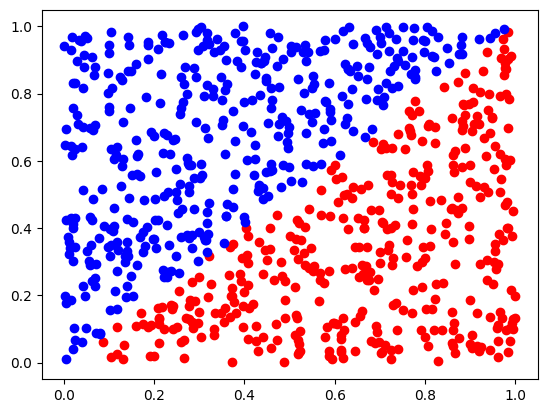

In [8]:
np.random.seed(0)
x, y = generate_linear(n=800)
test_x, test_y = generate_linear(n=200)
print(x[:5])
print(y[:5])
plt.plot(x[y.flatten() == 0, 0], x[y.flatten() == 0, 1], 'ro')
plt.plot(x[y.flatten() == 1, 0], x[y.flatten() == 1, 1], 'bo')
plt.show()

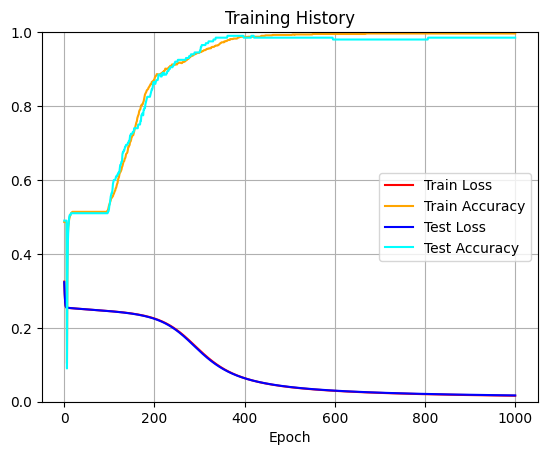

In [26]:
np.random.seed(0)
model = Model([2, 4, 4, 1])
model.train(x, y, test_x, test_y, epochs=1000, lr=1, batch_size=None, patience=None, verbose=False)

train_loss = [h.loss for h in model.train_histories]
train_accuracy = [h.accuracy for h in model.train_histories]
test_loss = [h.loss for h in model.test_histories]
test_accuracy = [h.accuracy for h in model.test_histories]
epochs = range(len(train_loss))

plt.xlabel('Epoch')
plt.plot(epochs, train_loss, label='Train Loss', color='red')
plt.plot(epochs, train_accuracy, label='Train Accuracy', color='orange')
plt.plot(epochs, test_loss, label='Test Loss', color='blue')
plt.plot(epochs, test_accuracy, label='Test Accuracy', color='cyan')
plt.title('Training History')
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [20]:
def show_result(x, y, pred_y):
    plt.subplot(1, 2, 1)
    plt.title("Ground truth", fontsize=18)
    for i in range(x.shape[0]):
        if y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')
    plt.subplot(1, 2, 2)
    plt.title("Predictl result", fontsize=18)
    for i in range(x.shape[0]):
        if pred_y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')
    plt.show()

Accuracy: 0.985
Loss: 0.01708260215251058


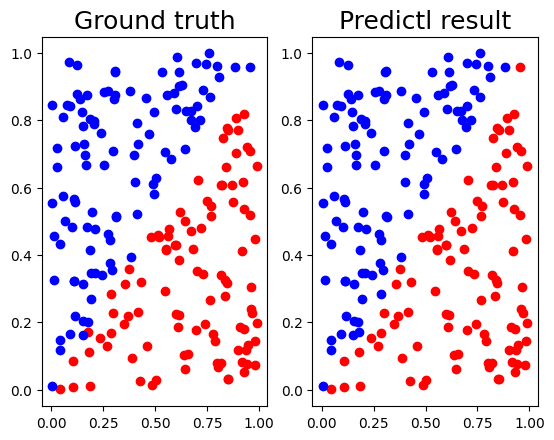

In [27]:
pred_y = model.forward(test_x)
pred_y = np.round(pred_y)
print(f"Accuracy: {model.accuracy(test_y)}")
print(f"Loss: {model.loss(test_y)}")
show_result(test_x, test_y, pred_y)